Goal - Implement standard QPE with simple controlled-phase unitary, known eigenstate

Ideal vs simulated noisy vs real hardware

/var/folders/p2/r0zl4pzj01z9f25h559679jw0000gn/T/ipykernel_2288/484662583.py:26: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  QFT(4, inverse=True, do_swaps=True),


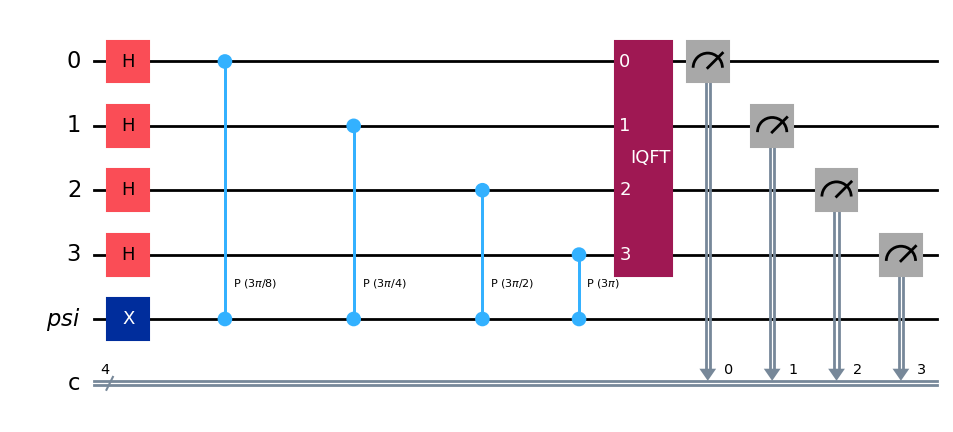

In [ ]:
'''
This section defines the Quantum Phase Estimation circuit itself. 
The circuit structure is independent of how it is executed (ideal simulator, noisy simulation, or real hardware).
QPE estimates the phase φ in the eigenvalue equation:
    U|ψ⟩ = e^{2πiφ} |ψ⟩
The phase is encoded into a binary bitstring using:
 - phase kickback via controlled-U operations
 - inverse QFT on the ancilla qubits
'''
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.circuit.library import QFT
import numpy as np
#n = 4 , ancilla has 4 bits
zero = QuantumRegister(1, "0") 
one = QuantumRegister(1, "1")
two = QuantumRegister(1, "2")
three = QuantumRegister(1, "3")
psi = QuantumRegister(1, "psi") #system qubit, where the U operator acts on and enables phase kickback
qc = QuantumCircuit(zero, one, two, three, psi, ClassicalRegister(4, "c"))
#already init to 0 state to prepare for superposition
qc.h(zero[0])
qc.h(one[0])
qc.h(two[0])
qc.h(three[0])
#all ancilla qubits are now in superposition via hadamard gates
#connected the ancilla qubits to the system qubit via controlled U operations, for qubit 0 it will be U^2^0
qc.x(psi) #preparing |1> state for phase kickback, making it an eigenstate of U. This is the formula U|1> = e^(iφ)|1> for phase kickback
theta = 3 * np.pi / 8   # corresponds to φ = 3/16, phase will be kicked back to ancilla qubits
qc.cp(theta, zero[0], psi[0]) #cp is controlled phase gate = controlled U, 0 is control qubit and psi is target
qc.cp(2 * theta, one[0], psi[0]) #for qubit 1 it will be U^2^1 etc
qc.cp(4 * theta, two[0], psi[0])  #basically just going to each bit
qc.cp(8 * theta, three[0], psi[0])
#inverse QFT on ancilla qubits
qc.append(
    QFT(4, inverse=True, do_swaps=True),
    [zero[0], one[0], two[0], three[0]]
)

qc.measure(zero, 0)
qc.measure(one, 1)
qc.measure(two, 2)
qc.measure(three, 3)
qc.draw('mpl')


Measured phase bitstring (ideal): 0011


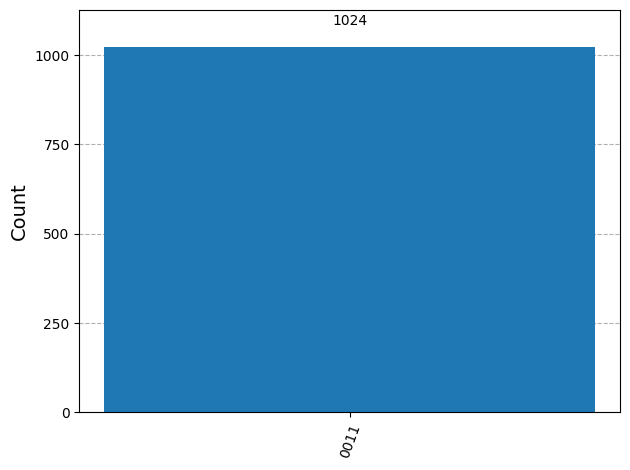

In [ ]:
'''
Executes the QPE circuit on an ideal statevector-based simulator.
No noise, decoherence, or measurement error is present.
Purpose to observe the expected phase bitstring without noise.
Output will be sharply peaked at the correct binary representation of the phase.
This execution represents the textbook behavior of Quantum Phase Estimation.
'''
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
backend = AerSimulator()
qc_t = transpile(qc, backend) #maps gates and qubits to the simulator's native representation
job = backend.run(qc_t, shots=1024) #run the job on the simulator
result = job.result() #get the results from the job
counts = result.get_counts(qc_t) #get the counts of each measured bitstring
most_likely = max(counts, key=counts.get) #find the bitstring with the highest count
print("Measured phase bitstring (ideal):", most_likely) #print the most likely bitstring
plot_histogram(counts) #no noise ideal example



qiskit_runtime_service.__init__:WARNING:2026-01-15 08:59:12,754: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-01-15 08:59:12,754: Using instance: open-instance, plan: open


Measured phase bitstring (noisy): 0011


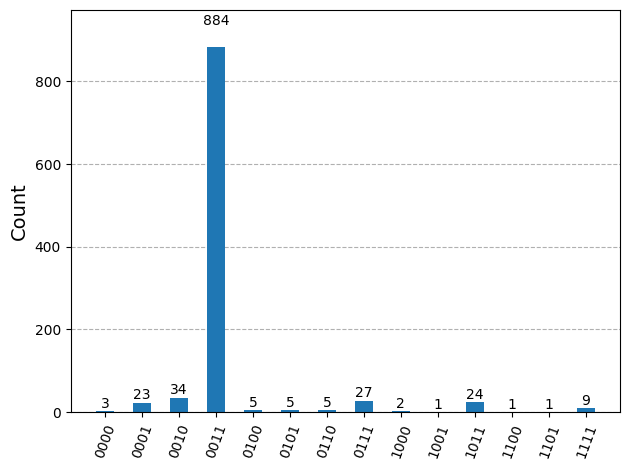

In [ ]:
'''
Executes the QPE circuit using a simulator augmented with a noise model extracted from a real IBM quantum device.

The noise model is built from device calibration data
(gate error rates, decoherence, and readout error)
allowing the circuit to be evaluated under NISQ-era conditions without actual hardware.

Expected behavior is a peak reduced compared to the ideal case
'''
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit import transpile
from qiskit.visualization import plot_histogram

# Connect to IBM Quantum
service = QiskitRuntimeService()

# Get real backend
ibm_backend = service.backend("ibm_fez")

# Extract realistic noise
noise_model = NoiseModel.from_backend(ibm_backend)

# Create noisy simulator
noisy_sim = AerSimulator(noise_model=noise_model)

qc_t = transpile(
    qc,
    backend=noisy_sim,
    optimization_level=1
)
job = noisy_sim.run(qc_t, shots=1024)
result = job.result()
counts = result.get_counts()
most_likely = max(counts, key=counts.get)
print("Measured phase bitstring (noisy):", most_likely)

plot_histogram(counts)

In [ ]:
# ---------------------------------------------------------
## This code CANNOT be executed under a free subscription, hence the lack of output
# ---------------------------------------------------------
'''
Execution of the QPE circuit on real IBM quantum hardware using the IBM Runtime primitives interface.

Execution is performed via a Runtime Session and the Sampler primitive, which submit circuits to a physical superconducting quantum device.

Steps taken: select a target IBM backend, transpiled the circuit for hardware-native gates, executed using the Sampler primitive, collected quasi-probability measurement results

This represents the physical-hardware execution path for QPE where noise and device imperfections arise from the quantum system itself.
'''
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session
from qiskit import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
service = QiskitRuntimeService()
backend = service.backend("ibm_fez") #select real hardware backend, used previously in my hello world noise demo
print("Running on backend:", backend.name)

qc_hw = transpile( #transpile for real hardware
    qc,
    backend=backend,
    optimization_level=1
)

with Session(backend=backend) as session:   
    sampler = Sampler(session=session)
    job = sampler.run([qc_hw], shots=1024)
    result = job.result()

quasi = result.quasi_dists[0] #extract quasi-probability distribution
counts = quasi.binary_probabilities() #convert to counts dictionary
most_likely = max(counts, key=counts.get)
print("Measured phase bitstring (real hardware):", most_likely)
print("Plotting histogram of results from real hardware execution")
plot_histogram(counts)

ReadTimeout: HTTPSConnectionPool(host='globalcatalog.cloud.ibm.com', port=443): Read timed out. (read timeout=60)